In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dataset = https://www.kaggle.com/minhhuy2810/rice-diseases-image-dataset/version/3

In [2]:
import os

In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/final_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/')

In [3]:
!zip -r /content/drive/My Drive/final_dataset.zip . -i /content/drive/My Drive/dataset_covid

	zip warning: name not matched: Drive/final_dataset.zip
	zip warning: name not matched: drive/My Drive/faster_rcnn_x101_64x4d_fpn_1x
Scanning files .........
zip I/O error: Operation not supported
zip error: Could not create output file (/content/drive/My.zip)


In [ ]:
import os

path, dirs, files = next(os.walk("/content/drive/My Drive/LabelledRice/Labelled/LeafBlast"))
file_count = len(files)
file_count

In [ ]:
%cd ..

/


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/"

In [ ]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [ ]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [03:13<00:00, 40.2MB/s]
100% 12.0G/12.0G [03:13<00:00, 66.6MB/s]


In [ ]:
!zip -r /content/gdrive/My.zip . -i /content/gdrive/My Drive/Kaggle_Rice/

	zip warning: zip file empty


In [ ]:
!ls

In [ ]:
base_dir = '/content/drive/My Drive/UCI_CV'

def create_path_list(category):
  images_in_path = os.listdir(os.path.join(base_dir,category))
  for index,item in enumerate(images_in_path):
    images_in_path[index] = base_dir + '/' + category + '/' + item
  return images_in_path

bacterial_leaf_blight_path = create_path_list('Bacterial leaf blight')
brownspot_path = create_path_list('Brown spot')
leaf_smut_path = create_path_list('Leaf smut')



In [ ]:
print(len(bacterial_leaf_blight_path) + len(brownspot_path) + len(leaf_smut_path))

120


In [ ]:
rice_split_dict_train = { }
rice_split_dict_train['bacterial_leaf_blight'] = bacterial_leaf_blight_path
rice_split_dict_train['brownspot'] = brownspot_path
rice_split_dict_train['leaf_smut'] = leaf_smut_path 


#bacterial_leaf_blight_path = 1
#brownspot_path = 2
#leaf_smut_path = 3

In [ ]:
import random
all_image_dict= {}
for category, path in rice_split_dict_train.items():
  for item in path:
    all_image_dict.update({item:category})

list_of_all_image_paths = list(all_image_dict.keys())
random.shuffle(list_of_all_image_paths)


In [ ]:
print(len(list_of_all_image_paths))

120


In [ ]:
import csv

with open('/content/drive/My Drive/train_data1.csv','w') as f:
  writer = csv.writer(f)
  writer.writerow(['image','label'])
  for item in list_of_all_image_paths:
    writer.writerow([item,all_image_dict[item]])
f.close()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,Conv2D,MaxPool2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
! pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-prwo3qn3
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-prwo3qn3
     |████████████████████████████████| 49.5MB 64kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28165 sha256=e41ed8dfc99e67fa34c5620a16183d608256f9cdc64177cbd6b755b8baad7389
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqexyows/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import ImageDataAugmentor
import cv2
import albumentations as albu

train_aug = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate(),
            albu.JpegCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.5)
            ])

In [ ]:
train_data = pd.read_csv('train_data1.csv')
Y = train_data[['label']]

kf = StratifiedKFold(n_splits=5, random_state = 7, shuffle = True)

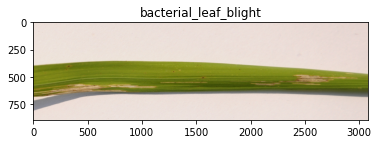

In [ ]:
from keras.preprocessing import image
img = plt.imread(list_of_all_image_paths[7])

plt.title(all_image_dict[list_of_all_image_paths[7]])
plt.imshow(img);

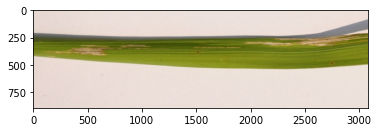

In [ ]:
def augmented_image(augmentation,image):
    
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix

aug_image = augmented_image(train_aug, img)

plt.imshow(aug_image)

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
image_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = train_aug,
        preprocess_input=None)

N_SAMPLES = len(list_of_all_image_paths)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))   

def densenet_model():

  temp_model =  tf.keras.applications.DenseNet169(weights='imagenet',include_top=False, pooling=max,input_shape=(224,224,3))

  for layer in temp_model.layers:
      layer.trainable = False

  #print(temp_model.summary())

  last_layer   =  temp_model.get_layer('relu')
  last_output = last_layer.output

  print(last_output)

  x = layers.AveragePooling2D((2,2),strides=1)(last_output)
  x = layers.Flatten()(last_output)
  x = layers.Dense(512,activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  predictions = Dense(3, activation='softmax')(x)
  model = Model(temp_model.input,predictions)
  
      
  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy',f1_m, precision_m, recall_m])
  
  return model



In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
VALIDATION_F1 = []
VALIDATION_RECALL = []
VALIDATION_PRECISION = []

for train_index, val_index in kf.split(np.zeros(N_SAMPLES),Y):

  tf.keras.backend.clear_session()

  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  train_data_generator = image_datagen.flow_from_dataframe(training_data,
                                                           directory=None,
                                                           x_col = 'image',
                                                           y_col='label',
                                                           class_mode='categorical',
                                                           batch_size=4,
                                                           target_size=(224,224),
                                                           shuffle=True)
  validation_data_generator=image_datagen.flow_from_dataframe(validation_data,
                                                              directory=None,
                                                              x_col='image',
                                                              y_col='label',
                                                              class_mode='categorical',
                                                              target_size=(224,224),
                                                              batch_size=4,
                                                              shuffle=True)
  model = densenet_model()
   
  history = model.fit(train_data_generator,
          epochs=20,
          steps_per_epoch=24,
          validation_data=validation_data_generator,
          validation_steps=6
         )
  

  model.trainable=True
  print("Number of layers in the base model: ", len(model.layers))
  fine_tune_at = 400
  for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001/10),
                  metrics=['accuracy',f1_m, precision_m, recall_m])


  print("trainable layers:", len(model.trainable_variables))

  fine_tune_epochs = 20
  total_epochs =  20 + fine_tune_epochs

  print("FINE TUNED TRAINING:")

  history_fine = model.fit(train_data_generator,
                         epochs=total_epochs,
                         steps_per_epoch=24,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data_generator,
                         validation_steps=6)

  loss, accuracy, f1_score, precision, recall = model.evaluate(validation_data_generator)

  print("accuracy",accuracy)
  print("f1_score",f1_score)
  print("precision",precision)
  print("recall",recall)  

  VALIDATION_ACCURACY.append(accuracy)
  VALIDATION_LOSS.append(loss)
  VALIDATION_F1.append(f1_score)
  VALIDATION_RECALL.append(recall)
  VALIDATION_PRECISION.append(precision)
  
  

 

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 5s 0us/step
Tensor("relu/Relu:0", shape=(None, 7, 7, 1664), dtype=float32)
Epoch 1/20
24/24 [==============================] - 101s 4s/step - loss: 1.6080 - accuracy: 0.5729 - f1_m: 0.5759 - precision_m: 0.5938 - recall_m: 0.5625 - val_loss: 3.7106 - val_accuracy: 0.4583 - val_f1_m: 0.4583 - val_precision_m: 0.4583 - val_recall_m: 0.4583
Epoch 2/20
24/24 [==============================] - 5s 191ms/step - loss: 0.8227 - accuracy: 0.6875 - f1_m: 0.6949 - precision_m: 0.7049 - recall_m: 0.6875 - val_loss: 1.3621 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - val_precision_m: 0.7083 - val_recall_m: 0.7083
Epoch 3/20
24/24 [==============================] - 5s 201ms/step - loss: 0.8170 - accuracy: 0.7812 - f1_m: 0.7812 - precision_m: 0.8090 - recall_m: 0.7604 - val_loss: 1.2416 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_

In [ ]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)
print(VALIDATION_F1)
print(VALIDATION_RECALL)
print(VALIDATION_PRECISION)

print('CV ACCURACY Average:',sum(VALIDATION_ACCURACY)/len(VALIDATION_ACCURACY))
print('CV LOSS Average:',sum(VALIDATION_LOSS)/len(VALIDATION_LOSS))
print('CV F1 Average:',sum(VALIDATION_F1)/len(VALIDATION_F1))
print('CV RECALL Average:',sum(VALIDATION_RECALL)/len(VALIDATION_RECALL))
print('CV PRECISION Average:',sum(VALIDATION_PRECISION)/len(VALIDATION_PRECISION))

[0.9583333134651184, 0.875, 0.9166666865348816, 0.7916666865348816, 0.7916666865348816]
[0.10458347946405411, 0.6159120202064514, 0.2147764414548874, 0.7916317582130432, 0.3850349187850952]
[0.9583333134651184, 0.875, 0.9166666865348816, 0.7916666865348816, 0.7976190447807312]
[0.9583333134651184, 0.875, 0.9166666865348816, 0.7916666865348816, 0.7916666865348816]
[0.9583333134651184, 0.875, 0.9166666865348816, 0.7916666865348816, 0.8055555820465088]
CV ACCURACY Average: 0.8666666746139526
CV LOSS Average: 0.4223877236247063
CV F1 Average: 0.8678571462631226
CV RECALL Average: 0.8666666746139526
CV PRECISION Average: 0.8694444537162781


In [ ]:
import csv
with open('/content/drive/My Drive/RESULTS_CV(20+20).csv','w') as f:
  writer = csv.writer(f)
  writer.writerow(['validation_accuracy','loss','f1','recall','precision'])
  for val_acc, val_loss,val_f1,val_recall,val_prec in zip(VALIDATION_ACCURACY,VALIDATION_LOSS,VALIDATION_F1,VALIDATION_RECALL,VALIDATION_PRECISION):
    writer.writerow([val_acc,val_loss,val_f1,val_recall,val_prec])
f.close()